# mDPP

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig
import os

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv, MDPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.models.rl.reinforce.baselines import CriticBaseline, RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.models.rl.reinforce.critic import CriticNetwork

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## mDPP Environment

We declare the environment here. This will automatically download the data 

In [2]:

data_dir = "../../data/"
data_file = "mdpp/mdpp10_test_seed1234.npz" # remember to generate data first


# In the mDPP problem we train directly on the test data as we want to search for best config
# of chip placement
env = MDPPEnv(reward_type="minmax", max_decaps=20, data_dir=data_dir,val_file=data_file, test_file=data_file)

In [3]:
bs = 10


td = env.load_data(os.path.join(data_dir, data_file))
td = env.reset(td)

td_init = td.clone()

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

for i in range(20):
    # pick random action from action_mask
    td = random_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions_ = torch.stack(actions, dim=1)

# env.render(td[0], actions_[0])

# for i in range(3):
#     env.render(td[i], actions_[i])

## Attention Model

In [4]:
td = env.generate_data([100])
td


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([100, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)

In [5]:
td = env.load_data(os.path.join(data_dir, data_file))
td

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([100, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([100, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)

In [6]:
# from rich.traceback import install
# install()

In [7]:
# Load environment with test data

dataset = env.dataset(phase="test")

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=tensordict_collate_fn,
)

policy = AttentionModelPolicy(
    env,
)

# model = torch.compile(model)

td = next(iter(dataloader))
td = env.reset(td)

out = policy(td, decode_type="greedy")

print(out)

{'reward': tensor([ 8.0818,  8.6294,  8.0309,  7.5548,  7.5584,  8.5488,  8.1506,  8.1958,
        10.1835,  7.1814,  7.6970,  7.7979, 10.1929,  7.6525,  7.8692,  9.0272,
         8.2007,  7.6549, 10.2054,  9.0773,  8.4902,  8.9773,  7.7156,  7.6426,
         8.5649,  8.5500,  9.0351,  7.9743,  7.8639,  7.4405,  8.3719,  7.4710,
         7.4666,  6.8183,  7.6592,  8.0897,  7.2101,  7.7987,  7.6069,  8.3751,
         7.8076,  8.4923,  7.5425,  7.4738,  8.9067,  7.8910,  8.1862,  7.4482,
         7.7275,  8.4361,  8.2795,  8.7471,  7.9357,  8.6422,  7.8697,  7.8149,
         7.7462, 11.4785,  7.2137,  8.4163,  7.5347,  8.2136,  9.4068,  7.3752]), 'log_likelihood': tensor([-76.1206, -71.1299, -72.5153, -70.1496, -67.7436, -74.2543, -71.0456,
        -72.7069, -58.4913, -75.7582, -70.7648, -65.0390, -64.9410, -71.1897,
        -71.4584, -63.3589, -68.2600, -71.8816, -55.4351, -68.0994, -70.2627,
        -55.9282, -77.0185, -71.3734, -67.9027, -73.0565, -77.4580, -69.0833,
        -70.1018,

In [8]:
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(
    env,
    policy,
    baseline,
)


td = next(iter(dataloader))

td = env.reset(td)
init_td = td.clone()


# out = model(td, decode_type="sampling")

# print(out)

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


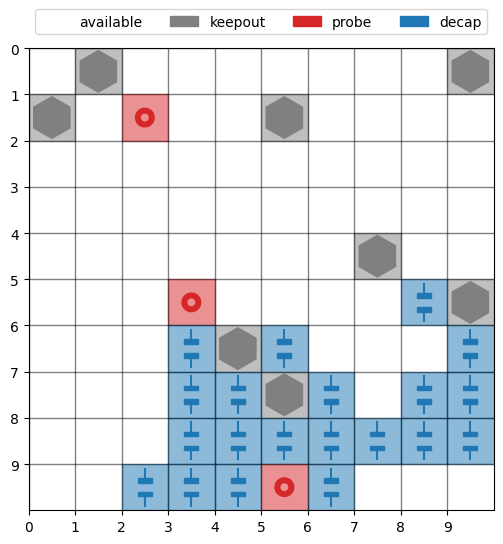

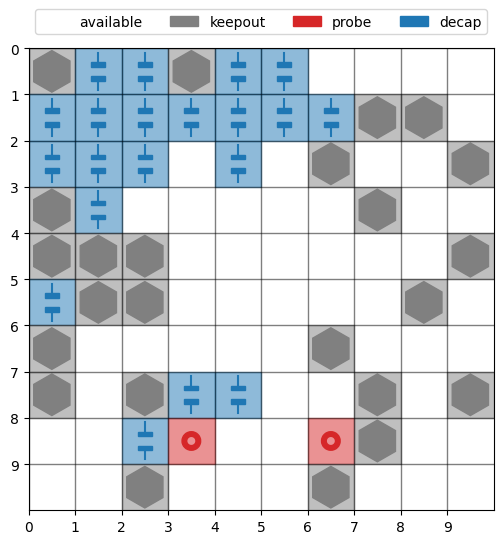

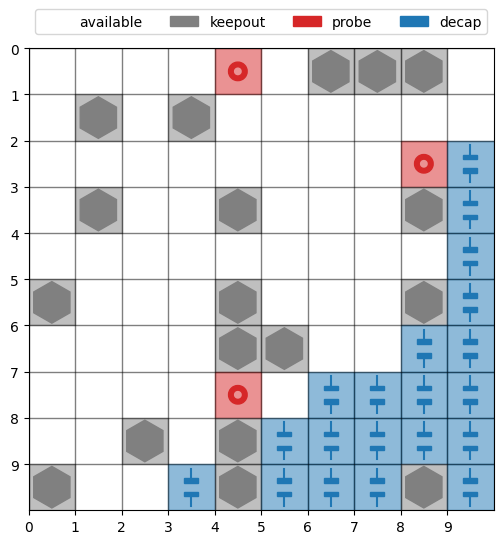

In [9]:
## Plot

probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(init_td[i], decaps[i])


# Main setup

In [10]:
config = DictConfig(
    {"data": {
            "train_size": 1000, # with 1 epochs, this is 1k samples
            "val_size": 100,
            "batch_size": 2,
    },
    "optimizer": {
        "lr": 3e-5,
        "weight_decay": 0,
    },
    "num_epochs": 10,
    })

# Recreate model (so CUDA is initialized in the model)

# baseline = ExponentialBaseline()
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(env, baseline=baseline)

lit_module = RL4COLitModule(cfg=config, env=env, model=model)

In [11]:
# Trainer
trainer = L.Trainer(
    max_epochs=config.num_epochs, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    devices=[0], # GPU number, or multiple GPUs [0, 1, 2, ...]
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
No optimizer specified, using default

  | Name  | Type           | Params
-----------------------------------------
0 | env   | MDPPEnv        | 0     
1 | model | AttentionModel | 1.5 M 
-----------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.810     Total estimated model params size (MB)
2023-06-07 22:36:44.177

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Results

In [12]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")
batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(9.4830, device='cuda:0')

/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


IndexError: index 2 is out of bounds for dimension 0 with size 2

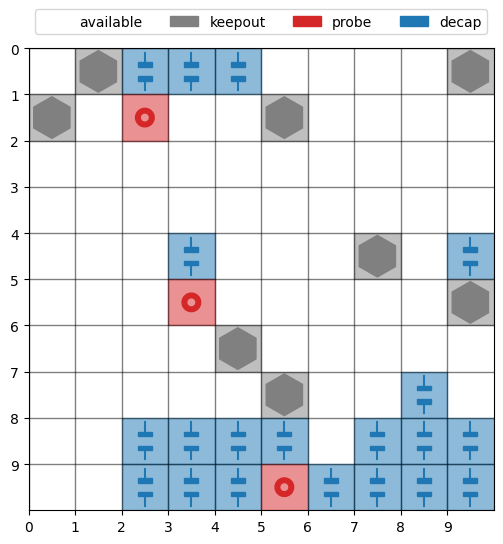

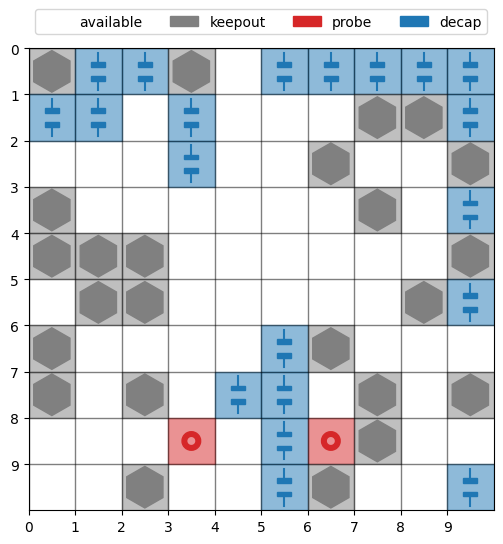

In [13]:
## Plot

init_td = env.reset(batch).to("cuda")
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(10):
    env.render(init_td[i], decaps[i])
